###Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import sys 
import math
import gc
import random
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import multivariate_normal
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import rbf_kernel
from collections import deque
from sklearn.cluster import KMeans
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

###Mounting the drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/Pattern Recognition/Assignment 2
%ls

/content/drive/.shortcut-targets-by-id/1545Xg-SmIx-Q5d7h4pQT5-xMVcs3ynu3/Pattern Recognition/Assignment 2
 dataset/          'Iris Evaluation.ipynb'  'Normalized Cut.ipynb'   Report.pdf
 Evaluation.ipynb   Kmean_DBSCAN.ipynb       PR_Assignment2.pdf


###Reading Datasets

In [4]:
#Drop Duplicates from both training and testing dataset
training = pd.read_csv('dataset/kddcup.data_10_percent.gz', header=None).drop_duplicates()
testing = pd.read_csv('dataset/corrected.gz', header=None).drop_duplicates()
print("training.shape =",training.shape)
print("testing.shape =",testing.shape)

training.shape = (145586, 42)
testing.shape = (77291, 42)


In [5]:
with open('dataset/kddcup.names.txt', 'r') as f:
    feature_names = f.read()

feature_names = feature_names.split('\n')[1:-1]  # split the string by newline characters and remove first and last elements
feature_names = [feature.split(':')[0] for feature in feature_names]  # extract the feature name from each element

feature_names.append('attack_type')
print("len(feature_names) =",len(feature_names))
print(feature_names)

len(feature_names) = 42
['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'attack_type']


###Showing the dataser using pandas dataframe

In [6]:
training.columns =feature_names
print("df.head()=\n",training.head().to_string(index=False))
print("df.shape =",training.shape)

testing.columns =feature_names
print("df.head()=\n",testing.head().to_string(index=False))
print("df.shape =",testing.shape)

df.head()=
  duration protocol_type service flag  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  num_failed_logins  logged_in  num_compromised  root_shell  su_attempted  num_root  num_file_creations  num_shells  num_access_files  num_outbound_cmds  is_host_login  is_guest_login  count  srv_count  serror_rate  srv_serror_rate  rerror_rate  srv_rerror_rate  same_srv_rate  diff_srv_rate  srv_diff_host_rate  dst_host_count  dst_host_srv_count  dst_host_same_srv_rate  dst_host_diff_srv_rate  dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  dst_host_srv_rerror_rate attack_type
        0           tcp    http   SF        181       5450     0               0       0    0                  0          1                0           0             0         0                   0           0                 0                  0              0               0      8          8          0.0              0.0         

In [7]:
#Removing last column which indicates the labels
training_labels = training['attack_type']
testing_labels =testing['attack_type']
training = training.iloc[:, :-1]
testing = testing.iloc[:, :-1]
print("training.shape =",training.shape)
print("testing.shape =",testing.shape)

training.shape = (145586, 41)
testing.shape = (77291, 41)


In [8]:
print("training.shape =",training_labels.shape)
print("testing.shape =",testing_labels.shape)

training.shape = (145586,)
testing.shape = (77291,)


###Encoding the dataset with numbers 

In [9]:
temp = pd.unique(training['protocol_type'])
tempList = list(range(0,len(temp)))
protocol_type = {temp[i]: tempList[i] for i in range(len(temp))}
print(protocol_type)

temp = pd.unique(training['service'])
tempList = list(range(0,len(temp)))
service = {temp[i]: tempList[i] for i in range(len(temp))}
print(service)

temp = pd.unique(training['flag'])
tempList = list(range(0,len(temp)))
flag = {temp[i]: tempList[i] for i in range(len(temp))}
print(flag)

temp = pd.unique(training_labels)
tempList = list(range(0,len(temp)))
attack_encoding = {temp[i]: tempList[i] for i in range(len(temp))}
print(attack_encoding)

temp = pd.unique(testing_labels)
tempList = list(range(0,len(temp)))
attack_testing = {temp[i]: tempList[i] for i in range(len(temp))}
print(attack_testing)

# Attack_Encoding is the final the encoding where each label is replaced with number
attack_encoding.update(attack_testing)
print(attack_encoding)

{'tcp': 0, 'udp': 1, 'icmp': 2}
{'http': 0, 'smtp': 1, 'finger': 2, 'domain_u': 3, 'auth': 4, 'telnet': 5, 'ftp': 6, 'eco_i': 7, 'ntp_u': 8, 'ecr_i': 9, 'other': 10, 'private': 11, 'pop_3': 12, 'ftp_data': 13, 'rje': 14, 'time': 15, 'mtp': 16, 'link': 17, 'remote_job': 18, 'gopher': 19, 'ssh': 20, 'name': 21, 'whois': 22, 'domain': 23, 'login': 24, 'imap4': 25, 'daytime': 26, 'ctf': 27, 'nntp': 28, 'shell': 29, 'IRC': 30, 'nnsp': 31, 'http_443': 32, 'exec': 33, 'printer': 34, 'efs': 35, 'courier': 36, 'uucp': 37, 'klogin': 38, 'kshell': 39, 'echo': 40, 'discard': 41, 'systat': 42, 'supdup': 43, 'iso_tsap': 44, 'hostnames': 45, 'csnet_ns': 46, 'pop_2': 47, 'sunrpc': 48, 'uucp_path': 49, 'netbios_ns': 50, 'netbios_ssn': 51, 'netbios_dgm': 52, 'sql_net': 53, 'vmnet': 54, 'bgp': 55, 'Z39_50': 56, 'ldap': 57, 'netstat': 58, 'urh_i': 59, 'X11': 60, 'urp_i': 61, 'pm_dump': 62, 'tftp_u': 63, 'tim_i': 64, 'red_i': 65}
{'SF': 0, 'S1': 1, 'REJ': 2, 'S2': 3, 'S0': 4, 'S3': 5, 'RSTO': 6, 'RSTR': 7,

In [10]:
#Replacing categorical features with numerical features 
#According to the encoding state prevoiusly
training = training.replace(protocol_type)
training = training.replace(service)
training = training.replace(flag)
training_labels = training_labels.replace(attack_encoding)

testing = testing.replace(protocol_type)
testing = testing.replace(service)
testing = testing.replace(flag)
testing_labels = testing_labels.replace(attack_encoding)

###Showing dataset after removing the label's column

In [11]:
feature_names.pop()
training.columns =feature_names
print("df.head()=\n",training.head().to_string(index=False))
print("df.shape =",training.shape)

testing.columns =feature_names
print("df.head()=\n",testing.head().to_string(index=False))
print("df.shape =",testing.shape)

df.head()=
  duration  protocol_type  service  flag  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  num_failed_logins  logged_in  num_compromised  root_shell  su_attempted  num_root  num_file_creations  num_shells  num_access_files  num_outbound_cmds  is_host_login  is_guest_login  count  srv_count  serror_rate  srv_serror_rate  rerror_rate  srv_rerror_rate  same_srv_rate  diff_srv_rate  srv_diff_host_rate  dst_host_count  dst_host_srv_count  dst_host_same_srv_rate  dst_host_diff_srv_rate  dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  dst_host_srv_rerror_rate
        0              0        0     0        181       5450     0               0       0    0                  0          1                0           0             0         0                   0           0                 0                  0              0               0      8          8          0.0              0.0          0.0  

###K-means

In [12]:
class K_Means():
    def __init__(self, n_clusters=4):
        self.k = n_clusters
        
    def fit(self, data, datalabels):
        self.trainingTrueLabels = datalabels
        n_samples, _ = data.shape
        # Pick Centeriods
        self.centers = np.array(random.sample(list(data), self.k))
        self.initial_centers = np.copy(self.centers)

        # This variable will be used to compare previous values with new 
        # centeriods to detect whether centeriods locations have been changed
        # or not when they equal each other iterations end
        old_assigns = None
        n_iters = 0

        while True:
            self.new_assigns = [self.classify(datapoint) for datapoint in data]
            #print(self.new_assigns)
            if self.new_assigns == old_assigns:
                print(f"Training finished after {n_iters} iterations!")
                return

            old_assigns = self.new_assigns
            n_iters += 1

            # recalculate centeriods
            for id_ in range(self.k):
                points_idx = np.where(np.array(self.new_assigns) == id_)
                datapoints = data[points_idx]
                self.centers[id_] = datapoints.mean(axis=0)
            

    def get_distance(self, datapoint):
        dists = np.sqrt(np.sum((self.centers - datapoint)**2, axis=1))
        return dists

    def classify(self, datapoint):
        # Get the centeriod that has the shortest distance between the point and
        # the centeriod
        dists = self.get_distance(datapoint)
        return np.argmin(dists)

    def predict_labels(self, data):
        # Predict the labels of the testing data
        return [self.classify(datapoint) for datapoint in data]

    def score(self,predicated,dataLabels):
      # Assign label to centeriod by viewing what is the most dominant label in it
      trueLabels = Counter(dataLabels)
      tLs=sorted(trueLabels.items(), key=lambda x:x[1], reverse=True)
      trueLabels = dict(tLs)
      predicatedLabels = Counter(predicated)
      # Get the cluster with the most elements
      pLs=sorted(predicatedLabels.items(), key=lambda x:x[1], reverse=True)
      predicatedLabels = dict(pLs)
      renaming_dict = {}
      # Map every cluster to each correct name by viewing the number of labels
      # in each one of them and comparing it with the true labels
      for tL, pL in zip(trueLabels.keys(),predicatedLabels.keys()):
        if pL == ():
          break
        renaming_dict[pL] = tL
      for i in range(len(predicated)):
        predicated[i]= renaming_dict[predicated[i]]
      unique = 0
      for i in range(len(predicated)):
        if (predicated[i] == dataLabels[i]):
          unique += 1
      return (unique/len(predicated))


###Evaluation

In [13]:
# Function to calculate the precision, recall and F1 score
def get_precision_recall_f1_score(k, y_pred, y_true):
    # check if y_pred and y_true are a numpy array
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    P = np.zeros(k)
    R = np.zeros(k)
    F = np.zeros(k)
    
    for i in range(k):
        # get indices of points in cluster i
        indices = np.where(y_pred == i)
        if len(indices[0]) == 0:
          continue
        # get the most frequent label in cluster i
        most_frequent_label = np.bincount(y_true[indices]).argmax()
        # get the number of points in cluster i that have the most frequent label
        number_of_points = np.sum(y_true[indices] == most_frequent_label)
        
        # get the number of points in cluster i
        number_of_points_in_cluster = len(indices[0])
        # Precision P = TP / (TP + FP)
        P[i] = number_of_points / number_of_points_in_cluster
        
        # get the number of points that have the most frequent label
        number_of_points_with_most_frequent_label = np.sum(
            y_true == most_frequent_label)
        # Recall R = TP / (TP + FN)
        R[i] = number_of_points / number_of_points_with_most_frequent_label
        
        # F1 score = 2 * P * R / (P + R)
        F[i] = 2 * P[i] * R[i] / (P[i] + R[i])
        
    # Average F1 score
    # F = np.mean(F)
    
    return P, R, F


In [14]:
def conditional_entropy(k, y_pred, y_true):
    # check if y_pred and y_true are a numpy array
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    # Get conditional entropy
    H = np.zeros(k)
    # Total entropy
    Ht = 0
    for i in range(k):
        # get indices of points in cluster i
        indices = np.where(y_pred == i)
        if not indices:
          continue
        # get the frequency of each label in cluster i
        print(i, indices)
        frequency = np.bincount(y_true[indices])
        # print("frequency = ", frequency)
        
        # get the probability of each label in cluster i
        probability = frequency / len(indices[0])
        # print("probability = ", probability)
        # Eliminate zero probability
        probability = probability[probability > 0]
        
        # get the entropy of each label in cluster i
        entropy= -probability * np.log10(probability)
        # print("entropy = ", entropy)
        
        # get the conditional entropy of cluster i
        H[i] = np.sum(entropy)
        # print("H[i] = ", H[i])
        
        # get the total entropy 
        Ht += H[i] * len(indices[0]) / len(y_true)
        # print("H[i] * len(indices[0]) / len(y_true) = ", H[i] * len(indices[0]) / len(y_true))
        
    return H, Ht

In [15]:
def plotAnomalyFscore(F):
  # Identifying threshold
  f1_scores = F
  threshold = F.mean()
  anomalies = f1_scores < threshold

  # Plot the F1-scores
  plt.plot(f1_scores, 'b-o', label='F1-score')

  # Highlight the anomalies in red
  plt.plot(np.where(anomalies)[0], f1_scores[anomalies], 'ro', label='Anomaly')

  # Add a horizontal line at the threshold
  plt.axhline(threshold, linestyle='--', color='g', label='Threshold')

  # Add labels and title
  plt.xlabel('Sample index')
  plt.ylabel('F1-score')
  plt.title('Anomaly detection with F1-score')

  # Add a legend
  plt.legend()

  plt.show()

In [16]:
def plotAnomalyEntropy(H,Ht):
  # Anomaly detection with Entropy
  entropy = H

  # Define the threshold for anomaly detection
  threshold = Ht

  # Detect anomalies
  anomalies = entropy < threshold

  # Plot the entropy values
  plt.plot(entropy, 'b-o', label='Entropy')

  # Highlight the anomalies in red
  plt.plot(np.where(anomalies)[0], entropy[anomalies], 'ro', label='Anomaly')

  # Add a horizontal line at the threshold
  plt.axhline(threshold, linestyle='--', color='g', label='Threshold')

  # Add labels and title
  plt.xlabel('Sample index')
  plt.ylabel('Entropy')
  plt.title('Anomaly detection with entropy')

  # Add a legend
  plt.legend()

  plt.show()

In [ ]:
ks = [7,15,23,31,45]
for k in ks:
  #KMeans Clustering used
  kmeans = K_Means(n_clusters=k)
  kmeans.fit(training.values, training_labels.values)
  labels = kmeans.predict_labels(testing.values)
  #Get cluster with highest true labels
  corrected_labels = Counter(labels)
  cL = sorted(corrected_labels.items(), key=lambda x:x[1], reverse=True)
  labels_2 = dict(cL)
  normal_cluster = list(labels_2.keys())[0]
  #Get indices of non-anamlous point which are not equal to zero
  anamoly_idx = np.where(np.array(labels) != normal_cluster)
  print("Number of anamolies in K={0} is {1}".format(k,len(list(anamoly_idx[0]))))

Training finished after 31 iterations!
Number of anamolies in K=7 is 1950
Training finished after 121 iterations!
Number of anamolies in K=15 is 10629
Training finished after 164 iterations!
Number of anamolies in K=23 is 28757
Training finished after 279 iterations!
Number of anamolies in K=31 is 34670
Training finished after 357 iterations!
Number of anamolies in K=45 is 64093


####Evaluating with K=23 for K-Means

In [17]:
kmeans = K_Means(n_clusters=23)
kmeans.fit(training.values, training_labels.values)
labels = kmeans.predict_labels(testing.values)
print("Score =", kmeans.score(labels,testing_labels.values))

Training finished after 154 iterations!
Score = 0.3144609333557594


<ipython-input-12-cab50c512986>:62: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if pL == ():


In [18]:
P, R, F = get_precision_recall_f1_score(23,labels, list(testing_labels.values))
print("P = ", P)
print("P mean =", P.mean())
print("R = ", R)
print("R mean =", R.mean())
print("F = ", F)
print("F mean =", F.mean())


P =  [0.47498068 0.96774194 1.         0.         0.41666667 0.875
 1.         0.         0.         0.9974953  0.99170124 1.
 0.92592593 0.66666667 0.9640884  0.         0.         0.99734631
 0.         0.99064449 0.         0.67354438 0.96231884]
P mean = 0.6045269927265091
R =  [5.00240018e-01 6.26134869e-04 2.08711623e-05 0.00000000e+00
 5.79345088e-01 1.46098136e-04 6.26134869e-05 0.00000000e+00
 0.00000000e+00 9.97432847e-02 4.98820779e-03 6.26134869e-05
 5.21779058e-04 8.34846493e-05 7.28403565e-03 0.00000000e+00
 0.00000000e+00 4.70644710e-02 0.00000000e+00 1.98902177e-02
 0.00000000e+00 4.97359798e-02 4.46236559e-01]
R mean = 0.0763500633549872
F =  [4.87283225e-01 1.25146004e-03 4.17414534e-05 0.00000000e+00
 4.84720759e-01 2.92147493e-04 1.25219133e-04 0.00000000e+00
 0.00000000e+00 1.81352459e-01 9.92648586e-03 1.25219133e-04
 1.04297038e-03 1.66948392e-04 1.44588296e-02 0.00000000e+00
 0.00000000e+00 8.98871926e-02 0.00000000e+00 3.89974425e-02
 0.00000000e+00 9.26318245e

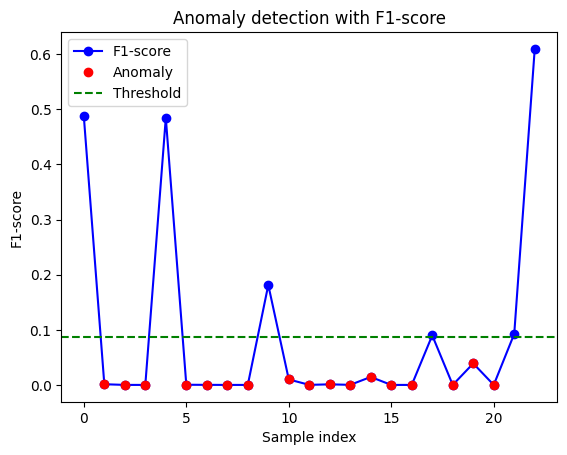

In [19]:
plotAnomalyFscore(F)

In [20]:
# calling the function
H, Ht = conditional_entropy(23, labels, list(testing_labels.values))
print("H = ", H)
print("Ht = ", Ht)

0 (array([    0,     1,     2, ..., 77288, 77289, 77290]),)
1 (array([  747,  1878,  2567,  2627,  4701,  7527,  7602, 14261, 14348,
       15404, 15819, 16652, 19568, 20285, 35421, 35712, 37544, 38065,
       41217, 42255, 43299, 43894, 44661, 45634, 46335, 48064, 56364,
       58014, 58713, 59822, 60345]),)
2 (array([3847]),)
3 (array([], dtype=int64),)
4 (array([  312,   420,   627, ..., 68776, 68779, 68780]),)
5 (array([13840, 33419, 37506, 40538, 41495, 61077, 62054, 65755]),)
6 (array([33104, 47602, 64054]),)
7 (array([], dtype=int64),)
8 (array([], dtype=int64),)
9 (array([   15,    18,    34, ..., 77088, 77105, 77108]),)
10 (array([  352,   482,   566,   654,   852,   937,  1158,  1470,  1970,
        2473,  2543,  2605,  2755,  2769,  2970,  3093,  3100,  3499,
        3620,  3683,  3852,  3906,  3998,  4020,  4198,  4203,  4230,
        4268,  4408,  4442,  4518,  4625,  4631,  4729,  4897,  4906,
        5060,  5090,  5219,  5234,  5253,  5300,  5413,  5420,  5563,
        5

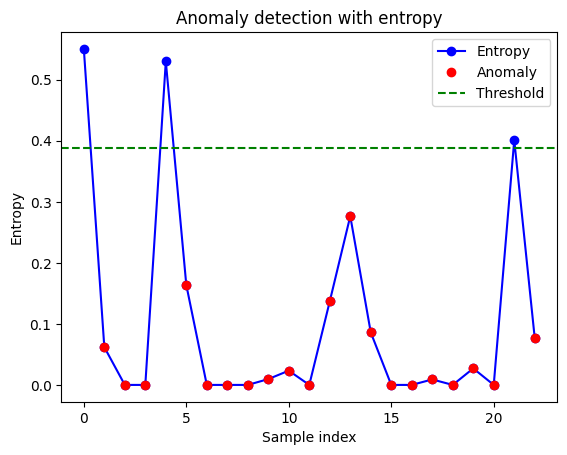

In [21]:
plotAnomalyEntropy(H,Ht)

###DBSCAN algorithm

In [22]:
class DBSCAN(object):
    UNCLASSIFIED = -2
    NOISE = -1
    
    def __init__(self, eps=0.5, min_pts=5):
        #epsilon here is the radius of circle that points will be compared to 
        #each other
        # min_pts the minumum number of points to exist in a circle and be called a cluster
        self.eps = eps
        self.min_pts = min_pts

    def fit_predict(self, X):
        labels = np.full([X.shape[0]], DBSCAN.UNCLASSIFIED)
        return self._fit_predict(X, labels)

    def _fit_predict(self, X, labels):
        # Go through points in dataset and classify them unless they are classified
        cluster_id = DBSCAN._next_id(DBSCAN.NOISE)
        for point_ind in range(X.shape[0]):
            if labels[point_ind] == DBSCAN.UNCLASSIFIED and self._expand_cluster(X, labels, point_ind, cluster_id):
                cluster_id = DBSCAN._next_id(cluster_id)
        return labels

    def _expand_cluster(self, X, labels, point_ind, cluster_id):
        # Add points to given cluster(cluster_id) if they are directly density reachable to given point(point_ind)
        # find epsilon-neighbourhood of given point and add them to given cluster otherwise classify them as noise
        region_inds = self._region_query(X, point_ind)
        if len(region_inds) < self.min_pts:
            labels[point_ind] = DBSCAN.NOISE
            return False

        # label these points to cluseter_id
        labels[region_inds] = cluster_id
        labels[point_ind] = cluster_id

        # create queue of points in the epsilon-neighbourhood and consider all points in the queue to possibly belong to cluster
        # detemine it testing direct density reachability
        queue_inds = deque(region_inds)
        while len(queue_inds):
            current_point_ind = queue_inds.popleft()

            result = self._region_query(X, current_point_ind)
            # test density reachability
            # on positive - consider only unclassified points and noises
            if len(result) > self.min_pts:
                is_noise = labels[result] == DBSCAN.NOISE
                is_unclassified = labels[result] == DBSCAN.UNCLASSIFIED
                
                # add only unclassified points
                queue_inds.extend(result[is_unclassified])
                # label these points to cluster_id
                labels[result[np.logical_or(is_noise, is_unclassified)]] = cluster_id
        return True

    def _region_query(self, X, point_ind):
        #  Find epsilon-neighbourhood of a given point(point_ind)
        d = np.sqrt(np.sum((X - X[point_ind]) ** 2, axis=1))
        mask = d < self.eps
        mask[point_ind] = False  # exclude this point
        return np.where(mask)[0] 

    @staticmethod
    def _next_id(cluster_id):
        return cluster_id + 1

In [23]:
d_training = training.values[0::2, :]
d_testing = training.values[1::2, :]

print("y_training.shape =",d_training.shape)
print("y_testing.shape =",d_testing.shape)

y_training.shape = (72793, 41)
y_testing.shape = (72793, 41)


In [24]:
y_training = training_labels.values[0::2]
y_testing = training_labels.values[1::2]

print("y_training.shape =",len(y_training))
print("y_testing.shape =",len(y_testing))

y_training.shape = 72793
y_testing.shape = 72793


In [25]:
DB = DBSCAN(eps=20,min_pts=5)
DB._fit_predict(d_training,y_training)
y_predicated = DB.fit_predict(d_testing)

In [26]:
NoiseIndices = np.where(y_predicated == -1)
y_labels = np.delete(y_predicated,NoiseIndices)
y_true = np.delete(y_training,NoiseIndices,axis=0)
k = len(np.unique(y_labels))

In [28]:
P, R, F = get_precision_recall_f1_score(k,y_labels, list(y_true))
print("P = ", P)
print("P mean =", P.mean())
print("R = ", R)
print("R mean =", R.mean())
print("F = ", F)
print("F mean =", F.mean())

P =  [1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.86596002
 0.98214286 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.98360656 1.
 1.         1.         1.         1.         0.98095238 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         0.98684211
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1

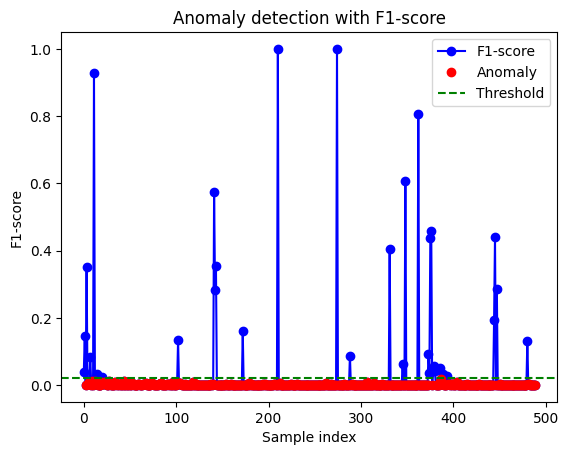

In [29]:
plotAnomalyFscore(F)

In [30]:
H, Ht = conditional_entropy(k, y_labels, list(y_true))
print("H = ", H)
print("Ht = ", Ht)

0 (array([    0,     8,    18,    73,   116,   240,   258,   268,   269,
         284,   289,   360,   361,   366,   373,   374,   376,   384,
         396,   401,   413,   581,   652,   661,   663,   681,   687,
         707,   724,   777,   916,   953,   962,   964,  1060,  1062,
        1066,  1070,  1075,  1086,  1221,  1294,  1295,  1297,  1314,
        1320,  1327,  1358,  1372,  1448,  1458,  1463,  1464,  1480,
        1481,  1483,  1516,  1517,  1520,  1671,  1682,  1683,  1735,
        1745,  1750,  1751,  1765,  1766,  1769,  1850,  1851,  1853,
        1857,  1892,  1904,  1914,  2097,  2098,  2115,  2117,  2126,
        2127,  2224,  2240,  2243,  2255,  2277,  2279,  2285,  2288,
        2290,  2342,  2376,  2385,  2550,  2551,  2553,  2563,  2568,
        2579,  2580,  2585,  2654,  2655,  2664,  2683,  2684,  2692,
        2703,  2711,  2764,  2848,  2860,  2873,  2941,  2958,  2963,
        2964,  2968,  2975,  2996,  3004,  3013,  3029,  3030,  3041,
        3042,  30

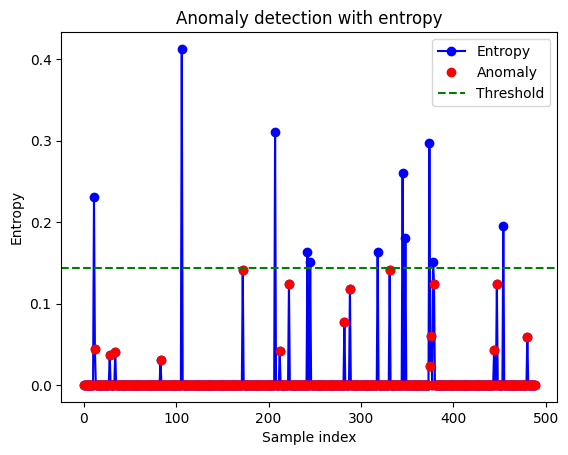

In [31]:
plotAnomalyEntropy(H,Ht)